In [1]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models
import torchvision

# import cv2
from pathlib import Path
from torch.nn import functional as F

from tqdm import tqdm_notebook, tqdm

In [2]:
from image_processing import upsample, downsample
from data import prepare_data, test_images_path,load_images_as_arrays
import os
from visualisation import (plot_coverage_and_coverage_class, 
                           scatter_coverage_and_coverage_class,
                           plot_depth_distributions,
                           plot_predictions,
                           plot_images)
from model import model_path
from metrics import iou_metric_batch, my_iou_metric, my_iou_metric_2
from toolz import compose
from data import run_length_encode, rle_encode
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils import data


In [3]:
from torchviz import make_dot

In [4]:
from shake_shake import Network, UNet

In [5]:
config = { "arch": "shake_shake",
    "base_channels": 96,
    "depth": 26,
    "shake_forward": True,
    "shake_backward": True,
"shake_image": True,
         "input_shape": (1, 1, 128, 128),
"n_classes": 10}

In [6]:
model=UNet(config)

In [7]:
x=torch.randn(32,1,128,128)

In [8]:
model.forward(x).shape

torch.Size([32, 192, 32, 32])
torch.Size([32, 384, 32, 32])
torch.Size([32, 96, 64, 64])
torch.Size([32, 192, 64, 64])
torch.Size([32, 48, 128, 128])
torch.Size([32, 96, 128, 128])


/opt/conda/envs/py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([32, 1, 128, 128])

In [9]:
device = "cuda"
img_size_target=128

In [11]:
model.train()
model.to(device)

UNet(
  (encoder): Network(
    (conv): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (stage1): Sequential(
      (block1): BasicBlock(
        (residual_path1): ResidualPath(
          (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (residual_path2): ResidualPath(
          (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1)

In [12]:
train_df, test_df = prepare_data()

100%|██████████| 4000/4000 [00:01<00:00, 2550.35it/s]


In [13]:
train_df.head()

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


/opt/conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


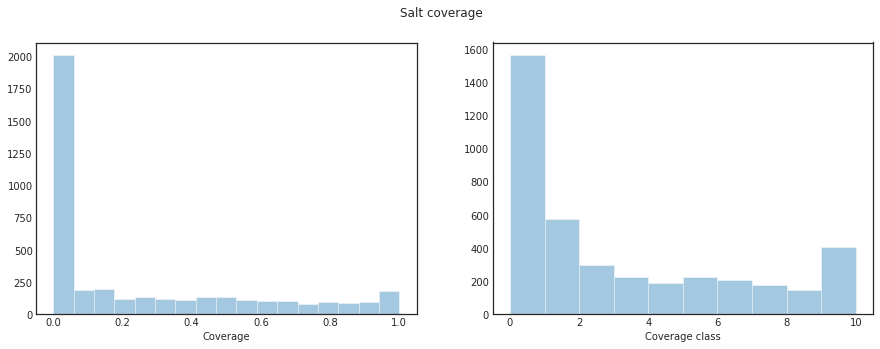

In [14]:
plot_coverage_and_coverage_class(train_df.coverage, train_df.coverage_class)

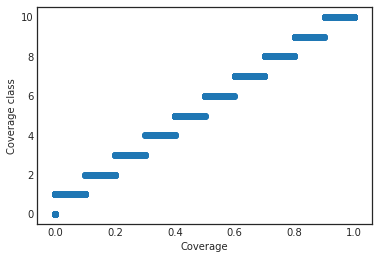

In [15]:
scatter_coverage_and_coverage_class(train_df.coverage, train_df.coverage_class)

/opt/conda/envs/py3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


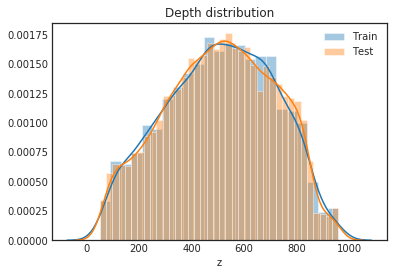

In [16]:
plot_depth_distributions(train_df.z, test_df.z)

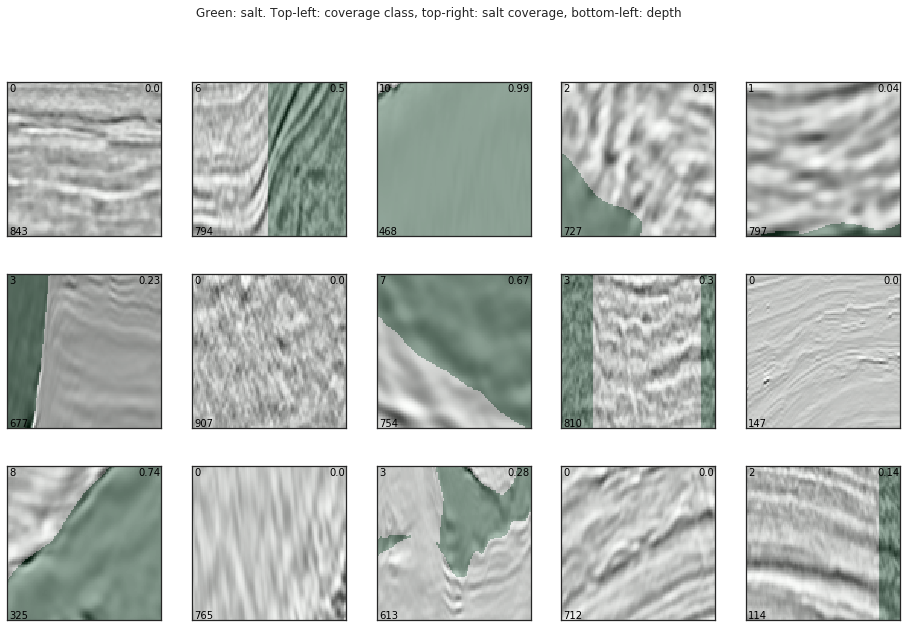

In [17]:
plot_images(train_df, max_images=15, grid_width=5, figsize=(16,10))

In [19]:
upsample_to = upsample(101,img_size_target)

In [27]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample_to).tolist()).reshape(-1, 1, img_size_target, img_size_target), 
    np.array(train_df.masks.map(upsample_to).tolist()).reshape(-1, 1, img_size_target, img_size_target), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

In [28]:
# Augment data with flipped verisons
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [29]:
x_train.shape

(6400, 1, 128, 128)

In [30]:
class TGSSaltDataset(data.Dataset):
    def __init__(self, x_data, y_data=None, is_test = False):
        self._is_test = is_test
        self._x_data=x_data
        self._y_data=y_data
    
    @property
    def is_test(self):
        return self._is_test
    
    def __len__(self):
        return len(self._x_data)
    
    def __getitem__(self, index):
        image=self._x_data[index]
        
        if self.is_test:
            return (image,)
        else:
            mask=self._y_data[index]
            return image, mask

In [31]:
dataset = TGSSaltDataset(x_train, y_data=y_train)
dataset_val = TGSSaltDataset(x_valid, y_data=y_valid)

In [34]:
batch_size=8
learning_rate = 1e-4
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for e in range(1):
    train_loss = []
    for image, mask in tqdm(data.DataLoader(dataset, batch_size = batch_size, shuffle = True)):
        image = image.type(torch.float).to(device)
        y_pred = model(image)
        loss = loss_fn(y_pred, mask.to(device))

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss.append(loss.item())
        
    val_loss = []
    for image, mask in data.DataLoader(dataset_val, batch_size = 50, shuffle = False):
        image = image.to(device)
        y_pred = model(image)

        loss = loss_fn(y_pred, mask.to(device))
        val_loss.append(loss.item())

    print("Epoch: %d, Train: %.3f, Val: %.3f" % (e, np.mean(train_loss), np.mean(val_loss)))

  0%|          | 0/800 [00:00<?, ?it/s]


RuntimeError: CUDA error: out of memory

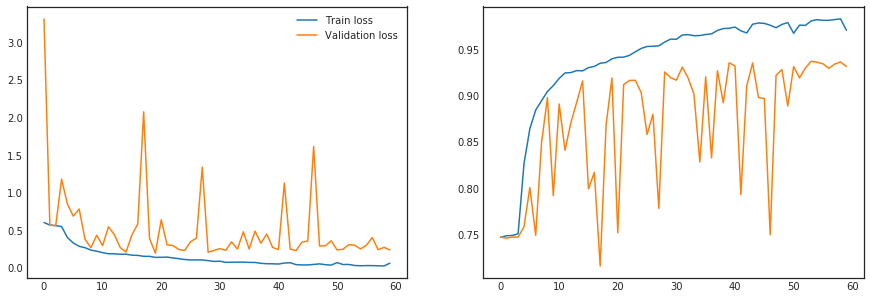

In [37]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax_loss.legend()

In [38]:
model_stage1 = load_model(model_filepath, custom_objects={'my_iou_metric': my_iou_metric})

In [39]:
model_stage1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 226, 226, 1)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 226, 226, 3)       30        
_________________________________________________________________
model_1 (Model)              (None, 226, 226, 1)       83796353  
Total params: 83,796,383
Trainable params: 83,725,343
Non-trainable params: 71,040
_________________________________________________________________


In [40]:
m_inner = model_stage1.layers[-1]

In [41]:
m_inner_new=Model(m_inner.layers[0].input, m_inner.layers[-1].input)

In [42]:
new_output = m_inner_new(model_stage1.layers[-2].output)

In [43]:
model = Model(model_stage1.input, new_output)

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 226, 226, 1)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 226, 226, 3)       30        
_________________________________________________________________
model_5 (Model)              (None, 226, 226, 1)       83796353  
Total params: 83,796,383
Trainable params: 83,725,343
Non-trainable params: 71,040
_________________________________________________________________


In [46]:

# output_layer = model_stage1.layers[-1].layers[-1].output
# model = Model(input_x, output_layer)
c = optimizers.adam(lr = 0.01)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

In [47]:
model_filepath=os.path.join(model_path(), 'stage2_keras.model')
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', 
                               mode = 'max', 
                               patience=20, 
                               verbose=1)
model_checkpoint = ModelCheckpoint(model_filepath,
                                   monitor='val_my_iou_metric_2', 
                                   mode = 'max', 
                                   save_best_only=True, 
                                   verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', 
                              mode = 'max',
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=1)
epochs = 50
batch_size = 16

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,reduce_lr,early_stopping], 
                    verbose=1)

Train on 6400 samples, validate on 800 samples
Epoch 1/50
6400/6400 [==============================] - 433s 68ms/step - loss: 0.2782 - my_iou_metric_2: 0.8146 - val_loss: 0.9926 - val_my_iou_metric_2: 0.6626

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.66263, saving model to /mnt/models/unet_resnet_pretrained/stage2_keras.model
Epoch 2/50
6400/6400 [==============================] - 399s 62ms/step - loss: 0.2454 - my_iou_metric_2: 0.8251 - val_loss: 0.5454 - val_my_iou_metric_2: 0.6995

Epoch 00002: val_my_iou_metric_2 improved from 0.66263 to 0.69950, saving model to /mnt/models/unet_resnet_pretrained/stage2_keras.model
Epoch 3/50
6400/6400 [==============================] - 398s 62ms/step - loss: 0.5445 - my_iou_metric_2: 0.7515 - val_loss: 279.5250 - val_my_iou_metric_2: 0.0402

Epoch 00003: val_my_iou_metric_2 did not improve from 0.69950
Epoch 4/50
6400/6400 [==============================] - 398s 62ms/step - loss: 0.5343 - my_iou_metric_2: 0.7147 - val_loss: 0.6171 -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6400/6400 [==============================] - 397s 62ms/step - loss: 0.1352 - my_iou_metric_2: 0.8614 - val_loss: 0.4177 - val_my_iou_metric_2: 0.7228

Epoch 00032: val_my_iou_metric_2 did not improve from 0.72963
Epoch 33/50
6400/6400 [==============================] - 397s 62ms/step - loss: 0.1310 - my_iou_metric_2: 0.8641 - val_loss: 0.4679 - val_my_iou_metric_2: 0.7212

Epoch 00033: val_my_iou_metric_2 did not improve from 0.72963
Epoch 34/50
6400/6400 [==============================] - 397s 62ms/step - loss: 0.1317 - my_iou_metric_2: 0.8633 - val_loss: 0.4266 - val_my_iou_metric_2: 0.7299

Epoch 00034: val_my_iou_metric_2 improved from 0.72963 to 0.72987, saving model to /mnt/models/unet_resnet_pretrained/stage2_keras.model
Epoch 35/50
6400/6400 [==============================] - 397s 62ms/step - loss: 0.1264 - my_iou_metric_2: 0.8666 - val_loss: 0.4200 - val_my_iou_metric_2: 0.7286

Epoch 00035: val_my_iou_metric_2 did not improve from 0.72987
Epoch 36/50
4672/6400 [==============

KeyboardInterrupt: 

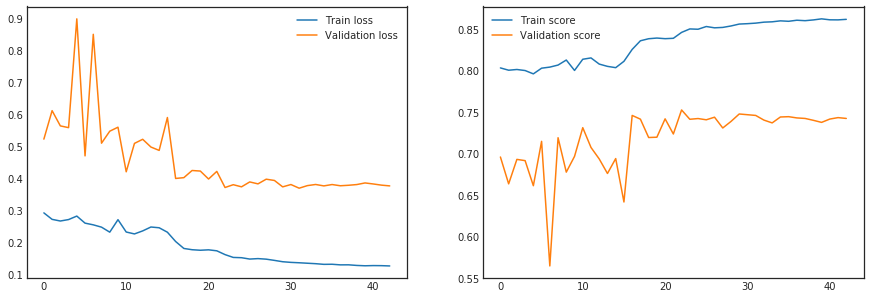

In [90]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [22]:
model = load_model(model_filepath,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

In [66]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [67]:
preds_valid = predict_result(model_stage1,x_valid,226)

In [68]:
# preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
# preds_valid = np.array([downsample128to101(x) for x in preds_valid])
# y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

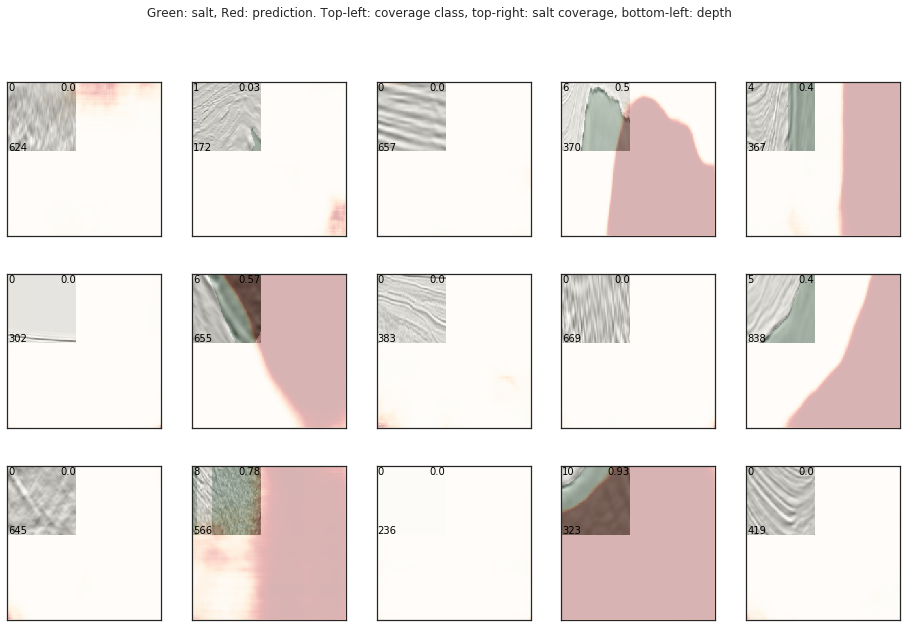

In [69]:
plot_predictions(train_df, preds_valid, ids_valid, max_images=15, grid_width=5, figsize=(16,10))

In [70]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

ious = list(map(lambda th: iou_metric_batch(preds_valid , np.int32(preds_valid > th)), 
                tqdm(thresholds)))

100%|██████████| 31/31 [01:42<00:00,  3.34s/it]


In [71]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

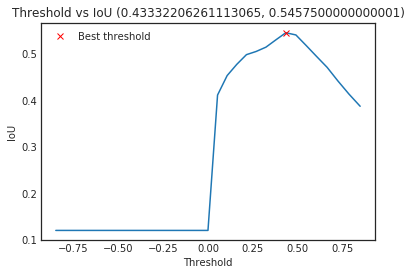

In [72]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [73]:
preds_thresh = list(map(lambda pred: np.array(np.round(pred > threshold_best), dtype=np.float32), preds_valid))

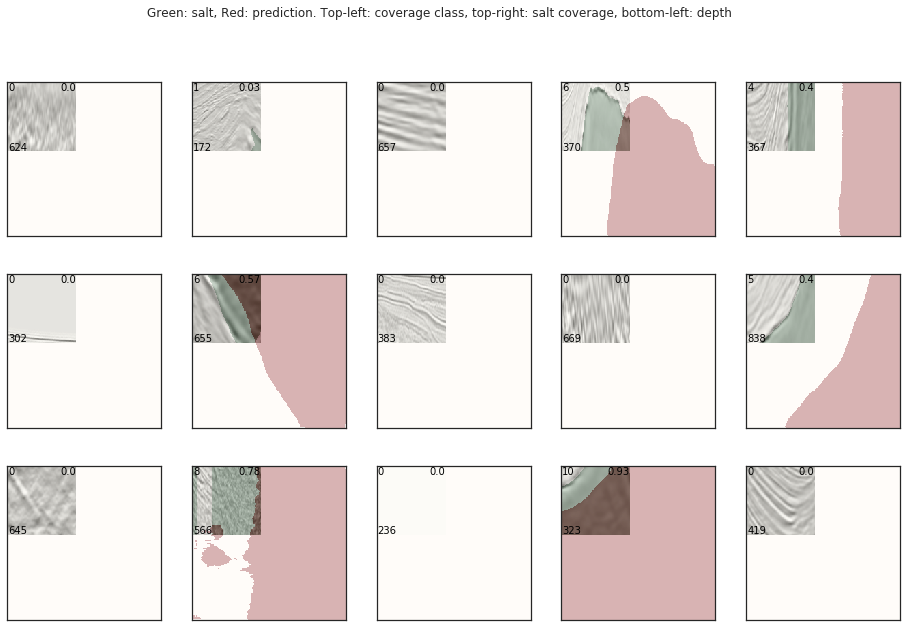

In [74]:
plot_predictions(train_df, preds_thresh, ids_valid, max_images=15, grid_width=5, figsize=(16,10))

In [75]:
x_test = load_images_as_arrays(test_df.index, test_images_path())

100%|██████████| 18000/18000 [00:14<00:00, 1238.62it/s]


In [76]:
x_test = list(map(upsample101to226, x_test))

In [77]:
# img_size_target=101
# x_test = load_images_as_arrays(test_df.index, test_images_path())
x_test = np.array(x_test)

In [78]:
x_test = x_test.reshape(-1, img_size_target, img_size_target, 1)

In [79]:
preds_test = predict_result(model_stage1,x_test,226)

In [80]:
preds_test[0].shape

(226, 226)

In [81]:
downsample226to101 = downsample(226, 101)

In [82]:
transform = compose(rle_encode, 
                    np.round,
                    downsample226to101,
                    lambda x: x > threshold_best)

In [83]:
pred_dict = {idx: transform(preds_test[i]) for i, idx in enumerate(tqdm(test_df.index.values))}

100%|██████████| 18000/18000 [00:21<00:00, 854.36it/s]


In [84]:
now = datetime.datetime.now()

In [85]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
filename=os.path.join(model_path(),f"submission_{now:%d%b%Y_%H}.csv")
sub.to_csv(filename)